# Imports

In [1]:
import numpy as np
import random
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm

# AE

In [ ]:
class Genetic:
    def __init__(self, population: np.ndarray, fitness_fn,
                 mutation_std: float = 0.1,
                 mutation_prob: float = 0.1,
                 crossover_prob: float = 0.5):
        self.population = population.copy()
        self.fitness_fn = fitness_fn
        self.mutation_std = mutation_std
        self.mutation_prob = mutation_prob
        self.crossover_prob = crossover_prob
        self.pop_size, self.chrom_len = population.shape
        self.generation = 0
        self.best_history = []

    def evaluate(self):
        return np.array([self.fitness_fn(ind) for ind in self.population])

    def find_best(self):
        fitness = self.evaluate()
        idx = np.argmax(fitness)
        return self.population[idx], fitness[idx]

    def select(self, fitness: np.ndarray):
        min_fit = np.min(fitness)
        if min_fit < 0:
            fitness = fitness - min_fit
        total = fitness.sum()
        probs = np.ones_like(fitness) / len(fitness) if total == 0 else fitness/total
        idxs = np.random.choice(self.pop_size, size=self.pop_size, p=probs)
        return self.population[idxs]

    def crossover(self, p1, p2):
        if random.random() < self.crossover_prob:
            pt = random.randrange(1, self.chrom_len)
            c1 = np.concatenate([p1[:pt], p2[pt:]])
            c2 = np.concatenate([p2[:pt], p1[pt:]])
        else:
            c1, c2 = p1.copy(), p2.copy()
        return c1, c2

    def mutate(self, individual):
        for i in range(self.chrom_len):
            if random.random() < self.mutation_prob:
                individual[i] += random.gauss(0, self.mutation_std)
        return individual

    def run(self, generations=1000, print_progress=True, log_history=False):
        for gen in range(1, generations+1):
            self.generation = gen
            fitness = self.evaluate()
            best, best_fit = self.find_best()

            if print_progress:
                print(f"Gen {gen:4d} | Best fitness = {best_fit:.6f}")

            if log_history:
                self.best_history.append(best_fit)
            pool = self.select(fitness)
            next_pop = []
            for i in range(0, self.pop_size, 2):
                p1, p2 = pool[i], pool[(i+1) % self.pop_size]
                c1, c2 = self.crossover(p1, p2)
                next_pop += [c1, c2]
            next_pop = np.array(next_pop[:self.pop_size])
            for i in range(self.pop_size):
                next_pop[i] = self.mutate(next_pop[i])

            self.population = next_pop

        return self.find_best()

# Helper functions

In [3]:
def plot_fitness_history(fitness_history):
    plt.figure(figsize=(10, 5))
    plt.plot(fitness_history)
    plt.title("Best Fitness over Generations")
    plt.xlabel("Generation")
    plt.ylabel("Best Fitness")
    plt.grid(True)
    plt.show()

# Testing

In [4]:
def funkcja1(vec):
    x, y, z = vec
    return - (x**2 + y**2 + 2*z**2)

def funkcja_rastringa(vec):
    A = 10
    return A*len(vec) + np.sum(vec**2 - A * np.cos(2*np.pi*vec))

def f2(vec):
    return - funkcja_rastringa(vec)

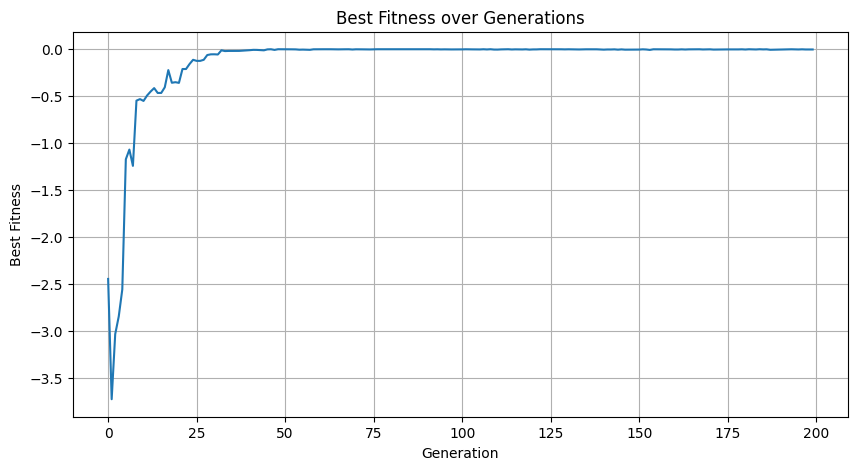

Best solution: [-0.01115341 -0.05229662  0.00655178]
Minimum f(x,y,z): 0.002945186605900699


In [5]:
pop1 = np.random.uniform(-5, 5, size=(50, 3))

ga1 = Genetic(
    population   = pop1,
    fitness_fn   = funkcja1,
    mutation_std = 0.1,
    mutation_prob= 0.2,
    crossover_prob=0.7
)

best_vec1, best_fit1 = ga1.run(
    generations   = 200,
    print_progress= False,
    log_history   = True
)

plot_fitness_history(ga1.best_history)
print("Best solution:", best_vec1)
print("Minimum f(x,y,z):", -best_fit1)


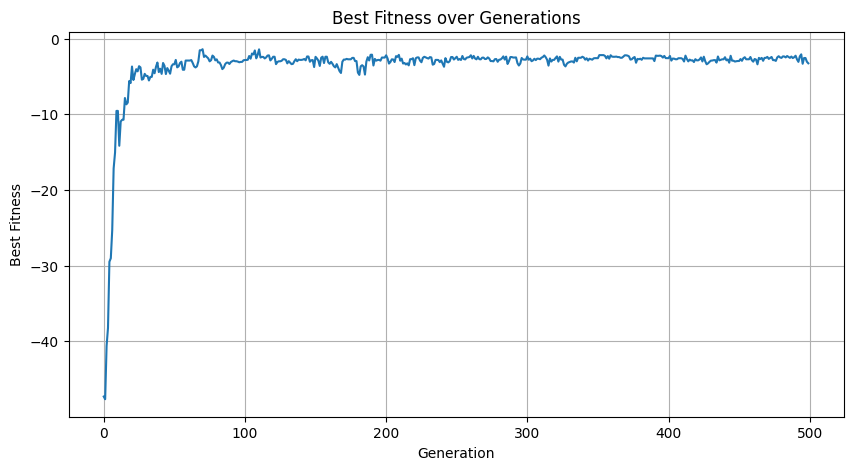

Best solution: [ 0.02401918  0.04665991 -0.06561841  1.01196924 -1.01136232]
Minimum Rastrigin value: 3.486034387834195


In [6]:
pop2 = np.random.uniform(-5.12, 5.12, size=(100, 5))
ga2 = Genetic(pop2, fitness_fn=f2,
              mutation_std=0.2,
              mutation_prob=0.1,
              crossover_prob=0.8)

best_vec2, best_fit2 = ga2.run(
    generations    = 500,
    print_progress = False,
    log_history    = True
)

plot_fitness_history(ga2.best_history)
print("Best solution:", best_vec2)
print("Minimum Rastrigin value:", -best_fit2)


# Eksperymenty własne

## Jak liczność populacji wpływa na zbieżność

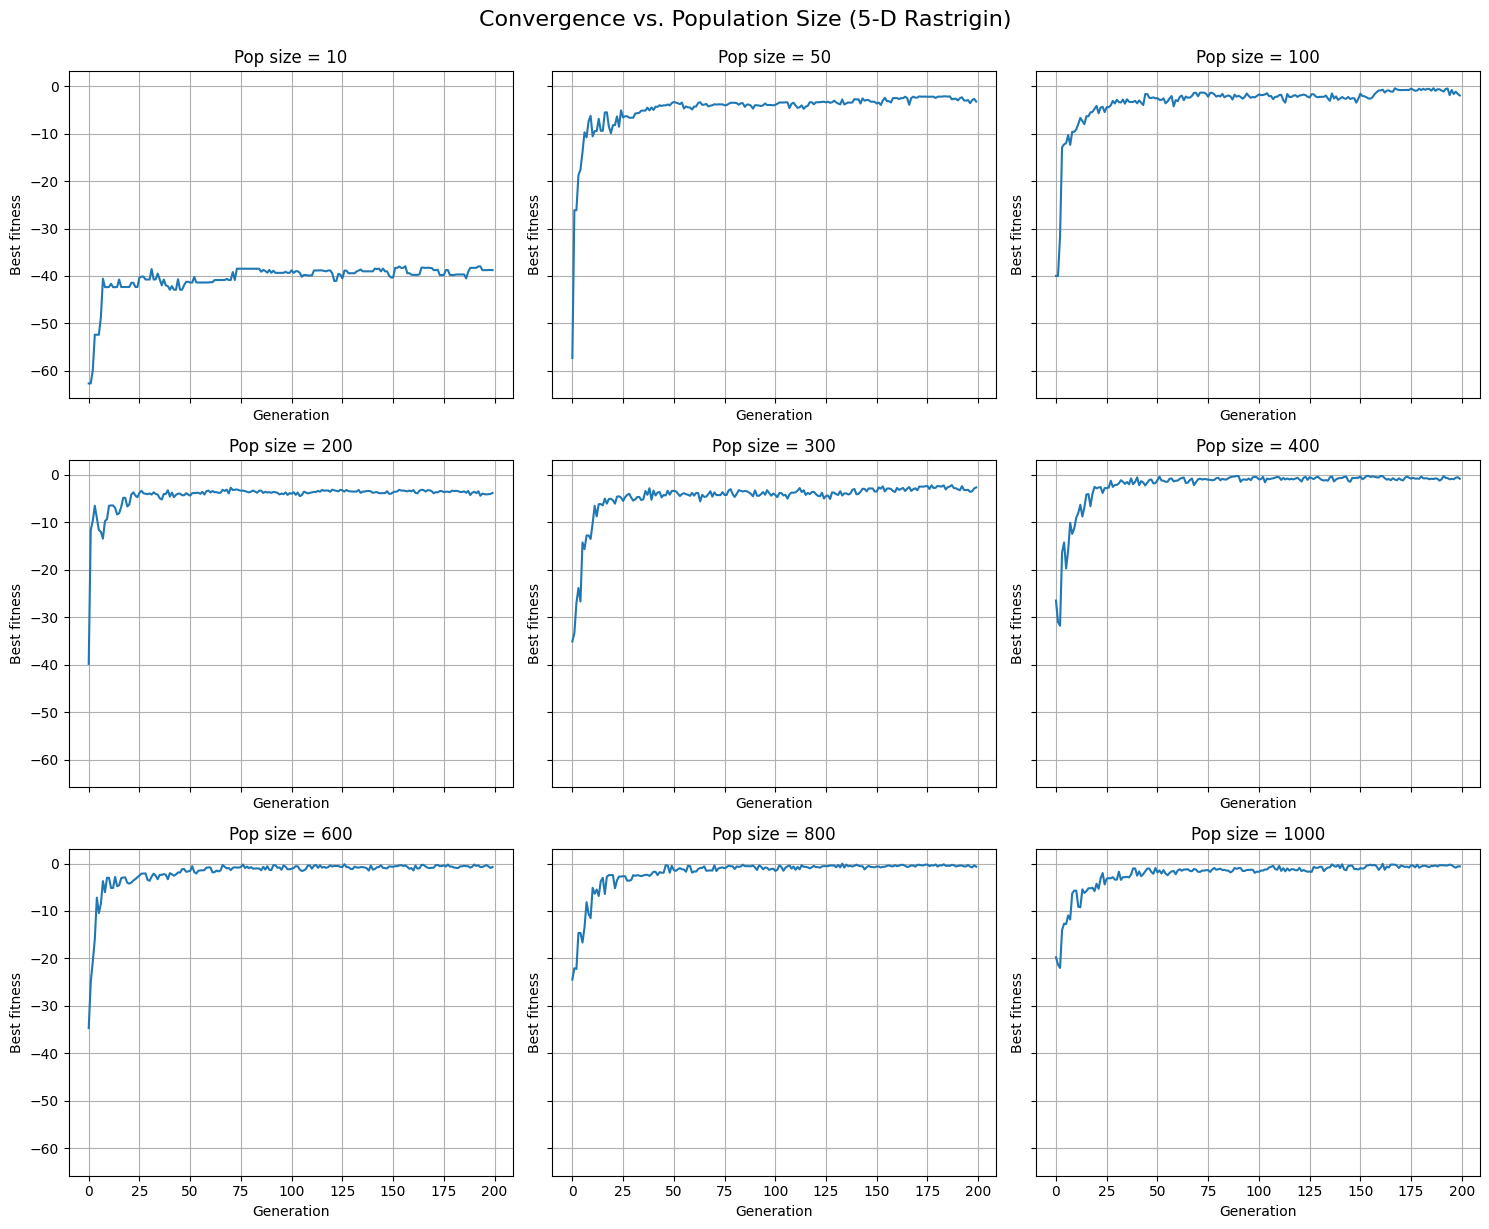

In [7]:
# List of 9 population sizes from small → large
pop_sizes = [10, 50, 100, 200, 300, 400, 600, 800, 1000]

n_gens      = 200
mutation_std= 0.2
mutation_p  = 0.1
crossover_p = 0.8

fig, axes = plt.subplots(3, 3, figsize=(15, 12), sharex=True, sharey=True)
axes = axes.flatten()

for ax, pop_size in zip(axes, pop_sizes):
    # initialize
    pop = np.random.uniform(-5.12, 5.12, size=(pop_size, 5))
    ga  = Genetic(
        population    = pop,
        fitness_fn    = f2,
        mutation_std  = mutation_std,
        mutation_prob = mutation_p,
        crossover_prob= crossover_p
    )
    # run, logging best each gen
    _, _ = ga.run(
        generations    = n_gens,
        print_progress = False,
        log_history    = True
    )
    # plot
    ax.plot(ga.best_history)
    ax.set_title(f"Pop size = {pop_size}")
    ax.set_xlabel("Generation")
    ax.set_ylabel("Best fitness")
    ax.grid(True)

plt.tight_layout()
plt.suptitle("Convergence vs. Population Size (5-D Rastrigin)", y=1.02, fontsize=16)
plt.show()

Wraz ze wzrostem populacji, widać że funkcja zbiega szybciej, ale co ważniejsze - zbiega do "mniejszego" minimum z większym prawdopodobieństwem -  populacji 10 widać że algorytm utknął w mało optymalnym minimum, natomiast już dla populacji >= 400 tego problemu nie ma.

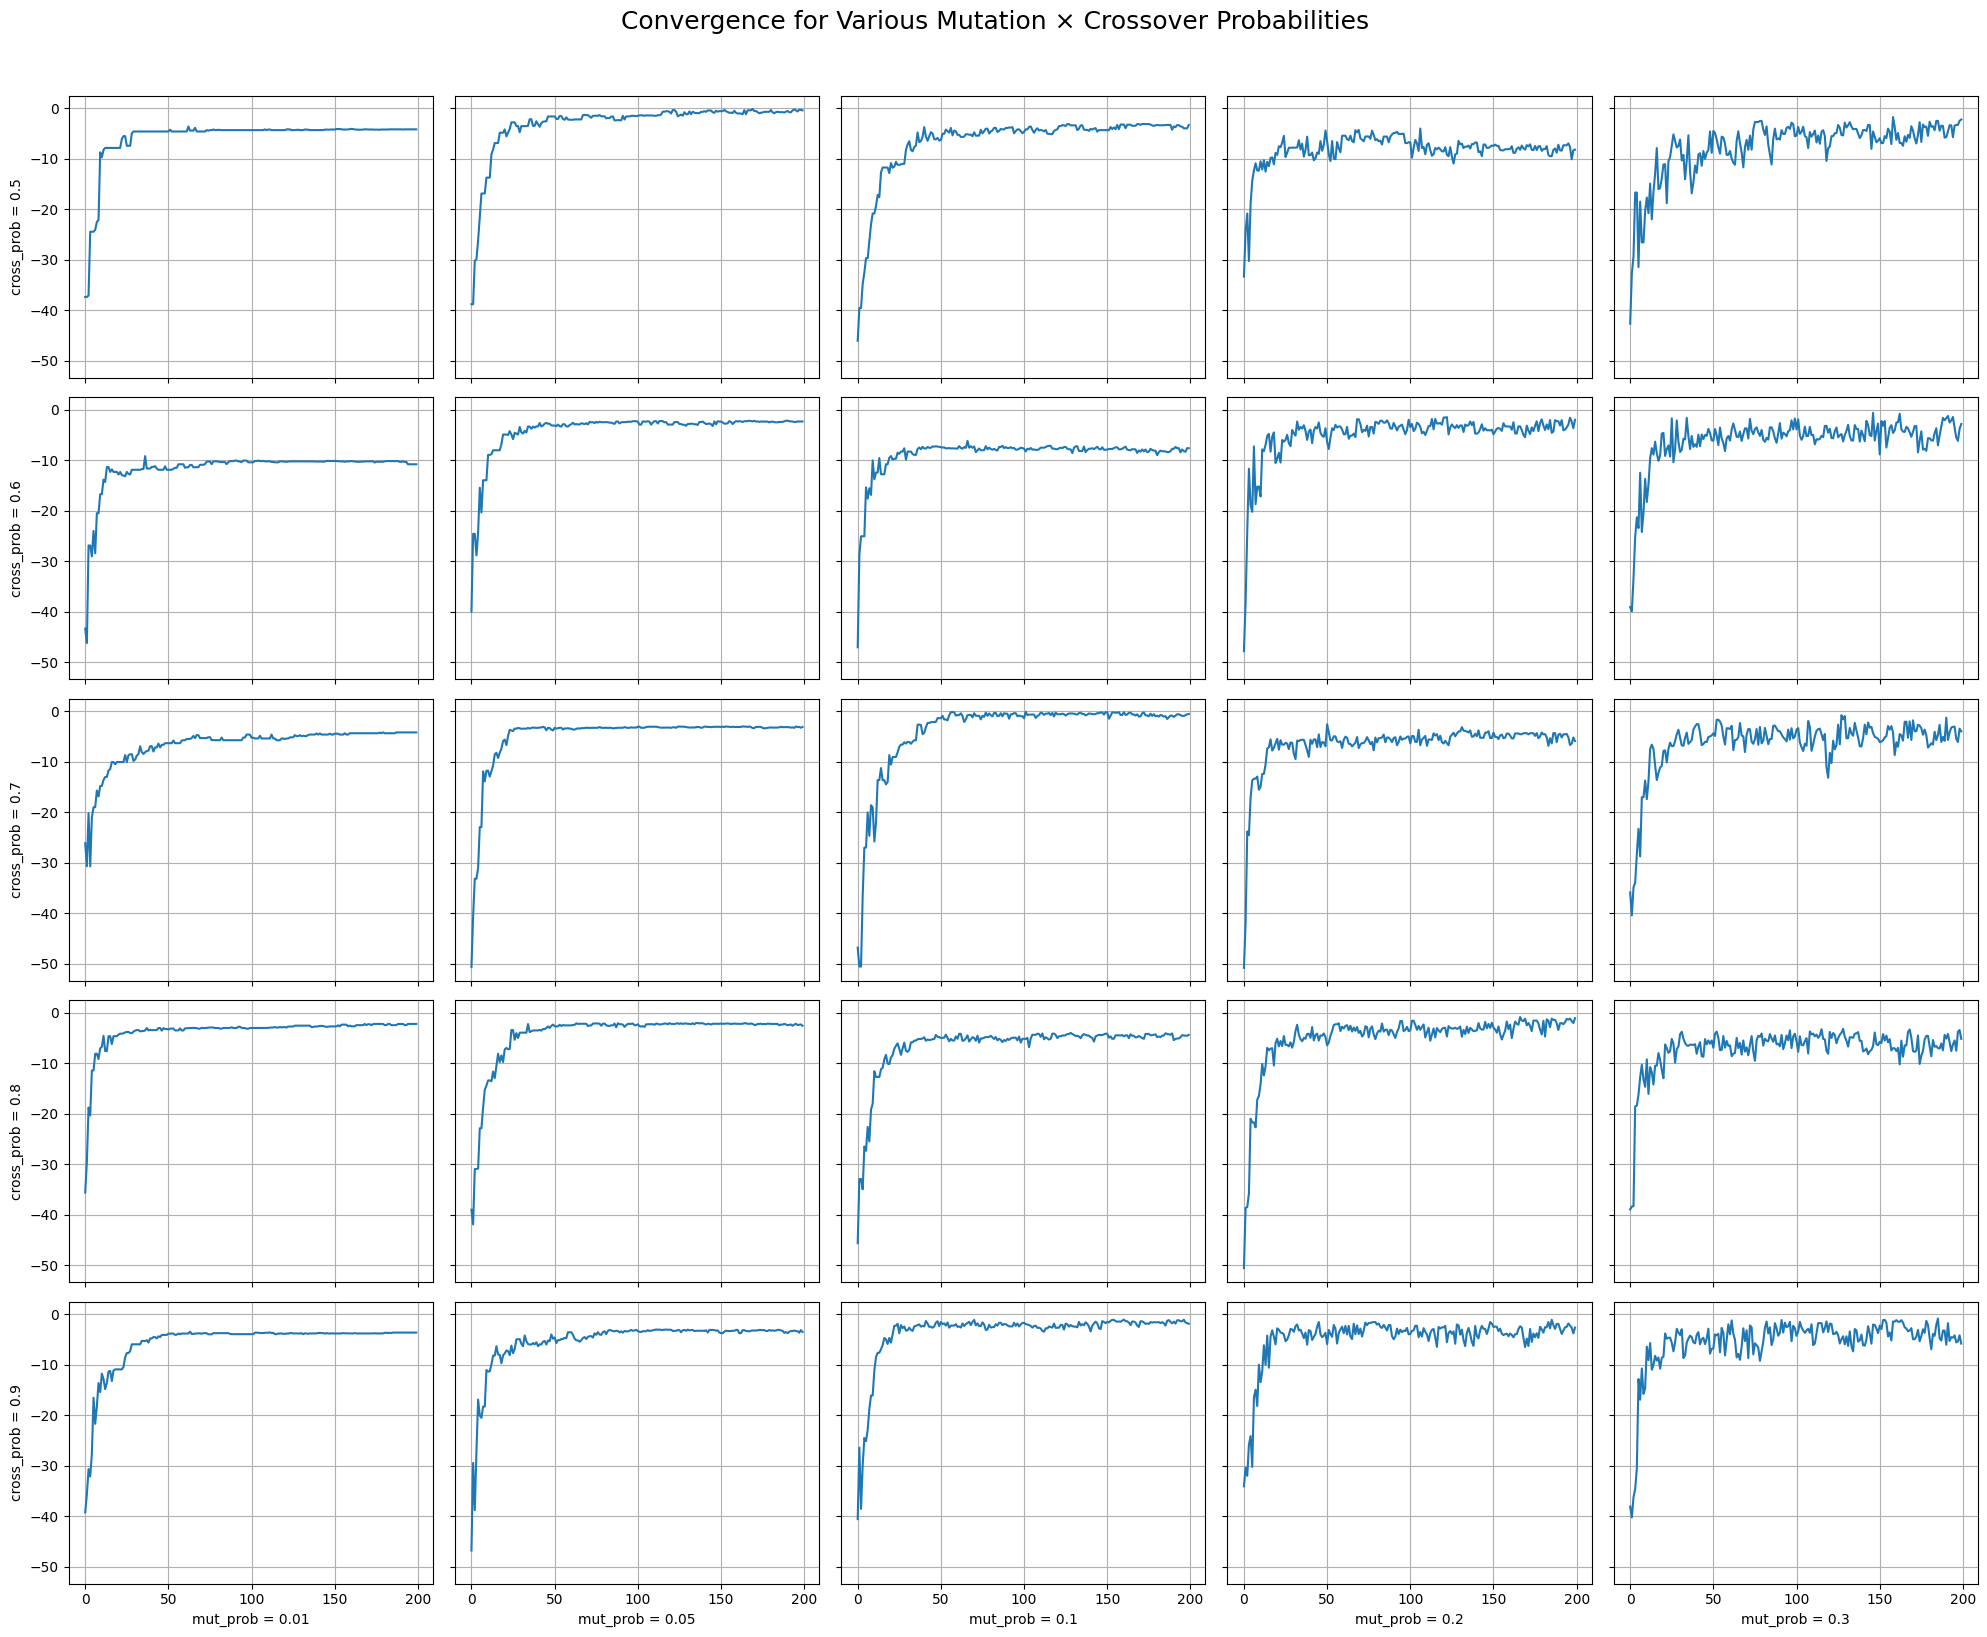

In [8]:
import numpy as np
import random
import matplotlib.pyplot as plt
from tqdm import trange

mutation_probs  = [0.01, 0.05, 0.1,  0.2,  0.3 ]
crossover_probs = [0.5,  0.6,  0.7,  0.8,  0.9 ]

pop_size = 100
n_gens   = 200
chrom_dim = 5

fig, axes = plt.subplots(
    nrows=len(crossover_probs),
    ncols=len(mutation_probs),
    figsize=(20, 16),
    sharex=True,
    sharey=True
)

for i, cp in enumerate(crossover_probs):
    for j, mp in enumerate(mutation_probs):
        
        pop = np.random.uniform(-5.12, 5.12, size=(pop_size, chrom_dim))
        ga  = Genetic(
            population     = pop,
            fitness_fn     = f2,
            mutation_std   = 0.2,
            mutation_prob  = mp,
            crossover_prob = cp
        )
        
        _, _ = ga.run(
            generations    = n_gens,
            print_progress = False,
            log_history    = True
        )

        ax = axes[i, j]
        ax.plot(ga.best_history)
        ax.grid(True)
        
        if i == len(crossover_probs) - 1:
            ax.set_xlabel(f"mut_prob = {mp}")
        if j == 0:
            ax.set_ylabel(f"cross_prob = {cp}")

plt.suptitle("Convergence for Various Mutation × Crossover Probabilities", y=1.02, fontsize=18)
plt.tight_layout()
plt.show()


Na podstawie powyższego wykresu, można stwierdzić, że zwiększenie prawdopodobieństwa mutacji znacząco przyspiesza zbieżność, natomiast im większe jest cross_prob tym mniej "stabilny" jest wynik i oscyluje wokół minimum.

Nawet małe prawdopodobieństwo mutacji zbiega stosunkowo szybko - już po 50 epokach wynik jest bliski minimum.